# Dependencies

```pip install cImage```

```pip install imageio```

# Adding Synthetic Data to Dataset

In [15]:
import tensorflow as tf

import pathlib
import imageio
import numpy as np

import random

from PIL import Image, ImageDraw, ImageFont



print(tf.__version__)

tf.enable_eager_execution()

1.14.0


In [17]:
data_root = "./data/generated_splits/3class/ali_relabeled_original/eval/"

# load an array of image paths where 
def load_image_paths(path):
    
    data_root = pathlib.Path(path)
    
    paths = []
    
    for child in sorted(data_root.iterdir(), key=(lambda x: x.name)):
        if (child.is_dir() and child.name != ".DS_Store"):
            print(child)
            
            subdir_paths = list(child.glob('**/*'))
            subdir_paths = [str(path) for path in subdir_paths if path.name != ".DS_Store"]
        
            paths.append(subdir_paths)
    
    return paths

paths = load_image_paths(data_root)

data/generated_splits/3class/ali_relabeled_original/eval/0
data/generated_splits/3class/ali_relabeled_original/eval/1
data/generated_splits/3class/ali_relabeled_original/eval/2


(512, 512)
255


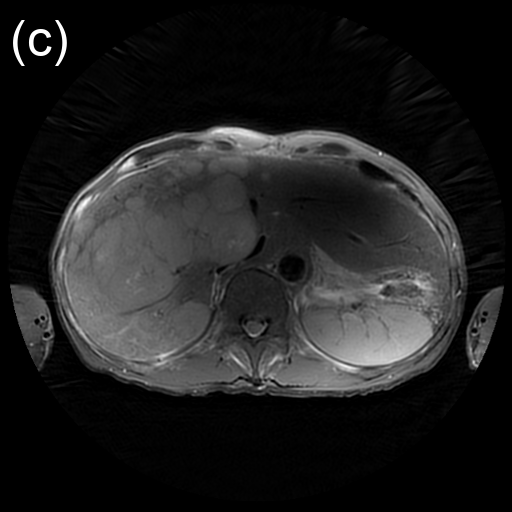

In [28]:
# 2 18 best result



    
image_path = paths[2][18]

# print(image_path)


image_contents = tf.read_file(image_path)

im_tensor = tf.image.decode_png(image_contents, channels=1)

im_max = tf.reduce_max(im_tensor)

# print(im_max)


im = imageio.imread(image_path)
print(im.shape)


print(np.max(im))

display1 = Image.fromarray(im)

display1_draw = ImageDraw.Draw(display1)

display1_draw.text((10,10), "(c)", fill="white", font=ImageFont.truetype("./fonts/arial.ttf", 50))

display(display1)


In [29]:
def ifftnc(x, axes):
    tmp = np.fft.fftshift(x, axes=axes)
    tmp = np.fft.ifftn(tmp, axes=axes)
    return np.fft.ifftshift(tmp, axes=axes)

def fftnc(x, axes):
    tmp = np.fft.fftshift(x, axes=axes)
    tmp = np.fft.fftn(tmp, axes=axes)
    return np.fft.ifftshift(tmp, axes=axes)

def fftc(x, axis=0, do_orthonorm=True):
    if do_orthonorm:
        scale = np.sqrt(x.shape[axis])
    else:
        scale = 1.0
    return fftnc(x, (axis,)) / scale

def ifftc(x, axis=0, do_orthonorm=True):
    if do_orthonorm:
        scale = np.sqrt(x.shape[axis])
    else:
        scale = 1.0
    return ifftnc(x, (axis,)) * scale

def fft2c(x, order='C', do_orthonorm=True):
    if order == 'C':
        if do_orthonorm:
            scale = np.sqrt(np.prod(x.shape[-2:]))
        else:
            scale = 1.0
        return fftnc(x, (-2, -1)) / scale
    else:
        if do_orthonorm:
            scale = np.sqrt(np.prod(x.shape[:2]))
        else:
            scale = 1.0
        return fftnc(x, (0, 1)) / scale

def ifft2c(x, order='C', do_orthonorm=True):
    if order == 'C':
        if do_orthonorm:
            scale = np.sqrt(np.prod(x.shape[-2:]))
        else:
            scale = 1.0
        return ifftnc(x, (-2, -1)) * scale
    else:
        if do_orthonorm:
            scale = np.sqrt(np.prod(x.shape[:2]))
        else:
            scale = 1.0
        return ifftnc(x, (0, 1)) * scale

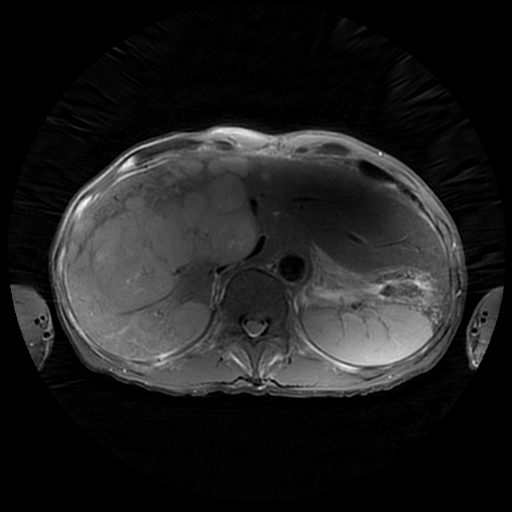

In [30]:
lf = 1200

def row_artifact(row, linear_factor):
        
    alpha = random.uniform(-1 * linear_factor, linear_factor)
    
    counter = 0
    for t in np.linspace(0, 0.002, num=row.size):
        row[counter] = row[counter] * np.exp(alpha * t )
        
        counter = counter + 1
        
    return row

def add_artifact(img, regions=[[0,511]], max_lf=500, seed=777): 
    
    random.seed(seed)
    
    for region in regions:
        
        for index in range(region[0], region[1]):
            img[index] = row_artifact(img[index], max_lf)
        
    return img

def reconstruct(img):

    img = np.absolute(ifft2c(img))
    img = np.around(img * 255.0 / np.max(img))

    return img

# convert to k-space
im_transformed = fft2c(im)

# add artifact
im_transformed_artifacted = add_artifact(im_transformed, regions=[], max_lf=lf)

# recon
image = reconstruct(im_transformed_artifacted)

image = np.uint8(image)
display2 = Image.fromarray(image)

# display2_draw = ImageDraw.Draw(display2)
# display2_draw.text((10,10), "(b)", fill="white", font=ImageFont.truetype("./fonts/arial.ttf", 50))

display(display2)

In [31]:
# generate a random range of values to apply shift on
def generate_random_range(start, end, artifact_length=[20,40], gap_length=[0,100], start_ofset=[0,20]):
    
    list = []
    
    current = start + random.randint(start_ofset[0], start_ofset[1])
    
    while current < end:
        
        increment = random.randint(artifact_length[0], artifact_length[1])
        
        if (current + increment > end):
            list.append([current, end])
            return list
        else:
            list.append([current, current + increment])
        
        current = current + increment + random.randint(gap_length[0], gap_length[1])
        
    return list
        
        
print(generate_random_range(0, 511))  

[[7, 41], [98, 129], [202, 230], [273, 310], [406, 427], [484, 511]]


data/generated_splits/3class/ali_relabeled_original/eval/0
data/generated_splits/3class/ali_relabeled_original/eval/1
data/generated_splits/3class/ali_relabeled_original/eval/2
data/generated_splits/3class/ali_relabeled_original/eval/2/IM-0016-0010-0001.dcm.png


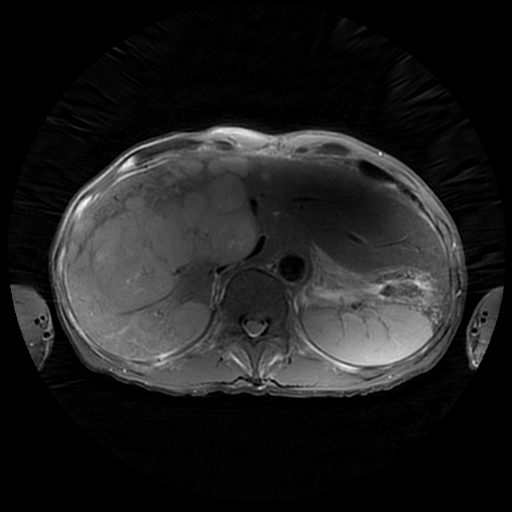

(512, 512)
[[14, 20], [55, 68], [99, 113], [147, 160], [189, 190], [222, 227], [267, 275], [293, 305], [326, 337], [357, 362], [373, 375], [395, 406], [429, 433], [444, 457], [485, 496]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


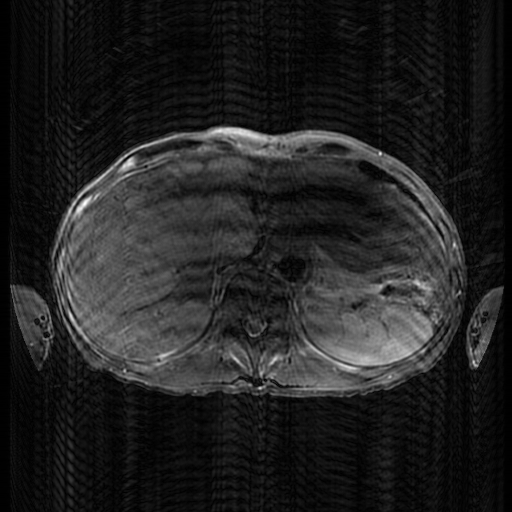

In [49]:
paths = load_image_paths(data_root)

image_path = paths[2][18]
print(image_path)
im = imageio.imread(image_path)

display4 = Image.fromarray(im)
display(display4)
print(im.shape)

im_transformed = fft2c(im)

# im_converted = np.abs(im_transformed) / np.max(np.abs(im_transformed)) * 255
# im_converted = np.uint8(im_converted)
# im_transformed_display = Image.fromarray(im_converted)

# display(im_transformed_display)


vals = generate_random_range(0, 511, artifact_length=[0,15], gap_length=[0,40], start_ofset=[10,20])
print(vals)

im_transformed_artifacted = add_artifact(im_transformed, regions=vals, max_lf=2000)

image = reconstruct(im_transformed_artifacted)
image = np.uint8(image)


print(image)

display3 = Image.fromarray(image)
display(display3)

# Generate Set of Synthetic Images

In [18]:
def add_motion_artifact(im, seed=777):
    
    random.seed(a=seed)
    
    im_transformed = np.fft.fft2(im)
    vals = generate_random_range(0, 511, artifact_length=[10,60], gap_length=[50,120], start_ofset=[0,50])
    print(vals)
    
    im_transformed_artifacted = add_artifact(im_transformed, regions=vals, max_lf=1200)

    image = reconstruct(im_transformed_artifacted)
    image = np.uint8(image)
    
    return image
    

In [22]:

### Input and Output DIRS
data_root_1 = "./data/data_relabeled_png/1/"
data_output = "./data/synthetic/0/"

# load an array of image paths
def load_image_paths(path):
    
    data_root = pathlib.Path(path)
    
    paths = []
    
    for child in data_root.iterdir():
        if (child.name != ".DS_Store"):
         
            paths.append(str(child))
    
    return paths

list_paths = load_image_paths(data_root_1)
print(list_paths[:10])

counter = 0

random.shuffle(list_paths)

# simulate on all 1 labels to create 0 label data
for image_path in list_paths:
    
    im = imageio.imread(image_path)
    
    im = add_motion_artifact(im, seed=counter)
    
    imageio.imwrite(data_output + "synthetic_" + str(counter) + ".png", im)
    
    counter = counter + 1




['data/data_relabeled_png/1/IM-0071-0019-0001.dcm.png', 'data/data_relabeled_png/1/IM-0017-0009-0001.dcm.png', 'data/data_relabeled_png/1/IM-0049-0016-0001.dcm.png', 'data/data_relabeled_png/1/IM-0005-0019-0001.dcm.png', 'data/data_relabeled_png/1/IM-0010-0002-0001.dcm.png', 'data/data_relabeled_png/1/IM-0019-0013-0001.dcm.png', 'data/data_relabeled_png/1/IM-0051-0019-0001.dcm.png', 'data/data_relabeled_png/1/IM-0040-0029-0001.dcm.png', 'data/data_relabeled_png/1/IM-0019-0026-0001.dcm.png', 'data/data_relabeled_png/1/IM-0026-0006-0001.dcm.png']
[[24, 82], [185, 197], [280, 322], [434, 469]]
[[8, 54], [112, 138], [203, 244], [351, 391], [489, 511]]
[[3, 18], [78, 111], [182, 239], [328, 354], [431, 479]]
[[15, 62], [181, 199], [296, 344], [454, 504]]
[[15, 44], [107, 163], [263, 303], [372, 387], [445, 456]]
[[39, 65], [160, 220], [337, 348], [457, 511]]
[[50, 96], [156, 197], [280, 292], [342, 361], [471, 511]]
[[20, 39], [139, 190], [246, 260], [378, 394], [490, 511]]
[[14, 47], [145,

[[48, 85], [201, 211], [317, 328], [419, 475]]
[[8, 26], [118, 177], [235, 255], [341, 356], [450, 462]]
[[38, 89], [158, 193], [299, 348], [455, 476]]
[[25, 79], [133, 186], [287, 319], [405, 432], [495, 511]]
[[4, 20], [102, 136], [203, 221], [278, 289], [361, 407], [462, 497]]
[[20, 55], [129, 153], [241, 281], [349, 369], [472, 487]]
[[45, 81], [157, 189], [275, 308], [372, 411]]
[[48, 83], [151, 185], [260, 275], [327, 344], [408, 419]]
[[31, 45], [99, 125], [228, 275], [365, 402], [483, 511]]
[[13, 73], [171, 212], [288, 326], [441, 451]]
[[37, 79], [198, 226], [329, 373], [491, 511]]
[[31, 67], [148, 207], [302, 321], [399, 419], [486, 511]]
[[39, 80], [158, 178], [230, 241], [335, 367], [446, 476]]
[[43, 67], [130, 143], [246, 292], [384, 442]]
[[25, 45], [152, 177], [293, 315], [389, 400]]
[[7, 49], [142, 177], [249, 296], [390, 445]]
[[33, 56], [176, 196], [275, 325], [436, 448]]
[[3, 57], [133, 175], [250, 286], [399, 458]]
[[34, 83], [191, 238], [310, 351], [437, 460]]
[[6,

[[38, 70], [164, 174], [286, 318], [435, 472]]
[[25, 75], [188, 232], [340, 391], [471, 511]]
[[35, 79], [199, 235], [345, 367], [421, 455]]
[[2, 27], [101, 116], [199, 245], [361, 396], [466, 502]]
[[8, 31], [135, 177], [284, 297], [376, 436]]
[[11, 57], [157, 207], [293, 336], [408, 463]]
[[27, 70], [144, 171], [247, 283], [381, 434], [488, 511]]
[[40, 82], [170, 228], [315, 358], [469, 506]]
[[11, 30], [131, 163], [260, 302], [386, 407]]
[[4, 33], [83, 101], [176, 201], [277, 301], [414, 427], [500, 511]]
[[35, 49], [123, 175], [258, 278], [364, 411]]
[[16, 42], [101, 138], [248, 267], [352, 397], [452, 496]]
[[41, 60], [158, 170], [238, 268], [347, 369], [477, 511]]
[[36, 56], [160, 200], [252, 274], [341, 354], [448, 479]]
[[12, 51], [115, 136], [186, 236], [323, 347], [448, 471]]
[[26, 80], [182, 213], [264, 297], [353, 368], [437, 494]]
[[1, 11], [101, 111], [189, 214], [326, 384], [435, 474]]
[[29, 40], [139, 150], [225, 250], [357, 412]]
[[44, 95], [151, 190], [291, 349], [452

[[15, 50], [168, 208], [307, 361], [478, 511]]
[[19, 66], [184, 235], [326, 380], [463, 500]]
[[46, 57], [155, 201], [280, 335], [408, 432], [499, 511]]
[[47, 85], [194, 231], [330, 390], [445, 494]]
[[48, 69], [162, 207], [291, 330], [423, 435], [506, 511]]
[[4, 52], [169, 207], [265, 280], [366, 408]]
[[41, 100], [169, 204], [256, 277], [383, 418], [510, 511]]
[[19, 75], [186, 243], [295, 330], [421, 431]]
[[46, 76], [134, 180], [299, 346], [449, 499]]
[[37, 89], [148, 182], [255, 266], [328, 338], [421, 477]]
[[13, 73], [183, 228], [288, 311], [428, 442]]
[[17, 37], [157, 206], [286, 310], [395, 440]]
[[12, 36], [93, 144], [197, 218], [297, 342], [414, 449], [510, 511]]
[[3, 20], [107, 129], [198, 216], [294, 336], [447, 506]]
[[16, 56], [157, 171], [224, 261], [323, 368], [456, 482]]
[[13, 47], [104, 151], [212, 233], [331, 350], [469, 508]]
[[16, 76], [164, 216], [298, 334], [432, 483]]
[[2, 58], [152, 173], [239, 282], [393, 448]]
[[43, 57], [145, 201], [310, 370], [461, 493]]
[[

[[40, 86], [175, 187], [259, 309], [386, 410], [481, 510]]
[[28, 64], [153, 181], [277, 307], [381, 414], [470, 489]]
[[34, 66], [133, 183], [276, 321], [376, 425]]
[[14, 37], [157, 205], [283, 299], [394, 423], [494, 505]]
[[17, 35], [100, 159], [276, 315], [424, 464]]
[[16, 40], [114, 129], [193, 239], [302, 313], [381, 403], [469, 504]]
[[14, 48], [107, 159], [231, 250], [336, 395], [488, 511]]
[[1, 55], [162, 205], [323, 344], [437, 480]]
[[44, 84], [192, 219], [310, 325], [422, 433]]
[[29, 81], [154, 192], [257, 287], [359, 413], [471, 484]]
[[32, 42], [111, 151], [224, 268], [319, 365], [445, 463]]
[[14, 51], [165, 205], [265, 323], [434, 456]]
[[20, 69], [185, 217], [311, 346], [462, 508]]
[[18, 31], [144, 195], [284, 294], [398, 408], [509, 511]]
[[2, 36], [107, 166], [224, 258], [314, 326], [388, 440]]
[[12, 24], [105, 128], [215, 261], [346, 377], [466, 509]]
[[26, 52], [113, 139], [240, 270], [382, 431], [494, 511]]
[[23, 82], [147, 171], [223, 275], [342, 392], [483, 511]]


[[39, 50], [163, 180], [236, 278], [341, 398], [489, 511]]
[[42, 62], [121, 157], [271, 306], [420, 445]]
[[2, 42], [123, 159], [244, 265], [338, 354], [471, 511]]
[[17, 41], [135, 162], [254, 308], [376, 405]]
[[46, 62], [125, 175], [286, 309], [417, 445]]
[[5, 31], [139, 167], [245, 286], [354, 404], [454, 511]]
[[0, 20], [83, 127], [221, 231], [350, 392], [462, 511]]
[[24, 45], [152, 211], [277, 334], [388, 419], [474, 511]]
[[24, 43], [115, 154], [252, 266], [354, 383], [451, 495]]
[[6, 51], [143, 196], [252, 274], [342, 372], [483, 510]]
[[11, 52], [148, 203], [294, 339], [452, 507]]
[[19, 29], [94, 140], [253, 291], [361, 385], [469, 511]]
[[31, 42], [112, 162], [267, 303], [355, 365], [431, 485]]
[[28, 88], [193, 210], [320, 330], [439, 496]]
[[14, 52], [159, 192], [276, 307], [425, 483]]
[[2, 34], [100, 158], [254, 306], [383, 419], [507, 511]]
[[36, 80], [152, 187], [301, 323], [401, 429]]
[[12, 67], [158, 213], [286, 325], [402, 438]]
[[13, 38], [139, 158], [248, 288], [346, 

[[43, 86], [171, 199], [280, 325], [405, 426], [494, 511]]
[[38, 68], [170, 221], [290, 321], [394, 405]]
[[22, 54], [155, 170], [242, 252], [331, 383], [456, 507]]
[[3, 45], [157, 179], [255, 312], [370, 424], [504, 511]]
[[30, 49], [146, 191], [244, 298], [400, 415], [477, 511]]
[[36, 94], [187, 226], [284, 338], [439, 490]]
[[5, 17], [102, 159], [257, 270], [359, 378], [441, 456]]
[[41, 77], [143, 192], [289, 310], [362, 405], [457, 505]]
[[40, 58], [119, 135], [209, 238], [336, 370], [422, 433]]
[[19, 55], [173, 192], [259, 318], [430, 454]]
[[12, 55], [113, 173], [260, 274], [380, 427]]
[[33, 48], [158, 185], [269, 315], [424, 448]]
[[27, 61], [167, 191], [280, 315], [387, 429]]
[[33, 49], [164, 214], [328, 364], [433, 450], [502, 511]]
[[33, 79], [151, 196], [310, 321], [380, 428], [503, 511]]
[[29, 54], [104, 115], [174, 200], [269, 300], [395, 415], [484, 511]]
[[43, 99], [207, 241], [297, 328], [400, 442]]
[[9, 46], [119, 131], [206, 223], [334, 389], [466, 500]]
[[34, 52], [1

[[7, 48], [154, 214], [331, 343], [399, 437], [501, 511]]
[[31, 65], [117, 165], [266, 293], [369, 427], [488, 511]]
[[20, 74], [124, 157], [216, 260], [314, 354], [457, 480]]
[[40, 74], [164, 185], [241, 297], [364, 378], [488, 511]]
[[27, 39], [116, 128], [243, 271], [390, 437], [508, 511]]
[[22, 41], [95, 136], [218, 230], [337, 396]]
[[43, 56], [134, 165], [259, 297], [375, 408], [510, 511]]
[[6, 24], [130, 164], [249, 262], [344, 385], [443, 479]]
[[34, 91], [202, 215], [286, 334], [404, 445]]
[[50, 91], [175, 189], [256, 290], [365, 399], [489, 511]]
[[30, 59], [173, 221], [279, 325], [400, 441]]
[[12, 56], [174, 186], [295, 322], [406, 419], [479, 511]]
[[13, 41], [152, 184], [274, 297], [368, 391], [502, 511]]
[[41, 53], [156, 193], [303, 328], [405, 422]]
[[41, 93], [212, 241], [305, 321], [413, 432], [491, 506]]
[[37, 89], [187, 217], [329, 350], [445, 491]]
[[12, 72], [124, 153], [251, 310], [385, 415], [490, 501]]
[[34, 86], [200, 241], [334, 370], [437, 467]]
[[20, 59], [1